<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Study-predictions" data-toc-modified-id="Study-predictions-1">Study predictions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Load-model-and-data" data-toc-modified-id="Load-model-and-data-1.3">Load model and data</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-1.4">Predictions</a></span></li><li><span><a href="#Current-metrics" data-toc-modified-id="Current-metrics-1.5">Current metrics</a></span></li><li><span><a href="#New-metrics" data-toc-modified-id="New-metrics-1.6">New metrics</a></span><ul class="toc-item"><li><span><a href="#Code" data-toc-modified-id="Code-1.6.1">Code</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-1.6.2">Visualizations</a></span><ul class="toc-item"><li><span><a href="#Cumulative-distributions-on-predictions" data-toc-modified-id="Cumulative-distributions-on-predictions-1.6.2.1">Cumulative distributions on predictions</a></span></li><li><span><a href="#Max-predictions-distributions" data-toc-modified-id="Max-predictions-distributions-1.6.2.2">Max predictions distributions</a></span></li><li><span><a href="#Importance-of-more-than-one-unit-actions" data-toc-modified-id="Importance-of-more-than-one-unit-actions-1.6.2.3">Importance of more than one unit actions</a></span></li><li><span><a href="#Correct-actions" data-toc-modified-id="Correct-actions-1.6.2.4">Correct actions</a></span></li><li><span><a href="#Other" data-toc-modified-id="Other-1.6.2.5">Other</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.7">Summary</a></span></li><li><span><a href="#Old-thoughts" data-toc-modified-id="Old-thoughts-1.8">Old thoughts</a></span></li></ul></li></ul></div>

# Study predictions

## Goal

The goal of this notebook is to study predictions of a model on the validation set with the aim to improve metrics or losses.

## Imports

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import luxai.cunet
from luxai.data import combine_data_for_training, load_match
from luxai.input_features import CHANNELS_MAP

In [10]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Load model and data

In [11]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/luxai/models/42_curriculum_learning_with_best_stages/seed0/stage4/best_val_loss_model.h5', compile=False)

In [12]:
df = pd.read_csv('/mnt/hdd0/Kaggle/luxai/models/42_curriculum_learning_with_best_stages/seed0/stage4/val.csv')
df.head()

,Id,EpisodeId,Index,Reward,State,SubmissionId,InitialConfidence,InitialScore,UpdatedConfidence,UpdatedScore,FinalScore,Team
0,75076972,29991187,0,890041.0,2,23297953,35.00000,1957.279341,35.000000,1959.003122,2021.185199,Toad Brigade
1,75988959,30447180,1,1310051.0,2,23297953,35.00000,2011.593075,35.000000,2013.044434,2021.185199,Toad Brigade
2,72070727,28487063,1,230012.0,2,23297953,42.79739,1466.705040,42.321043,1472.138593,2021.185199,Toad Brigade
3,74444543,29674972,1,1030042.0,2,23297953,35.00000,1932.343041,35.000000,1933.920986,2021.185199,Toad Brigade
4,73255322,29079361,0,310016.0,2,23297953,35.00000,1819.460414,35.000000,1821.367935,2021.185199,Toad Brigade


In [15]:
def load_data(df):
    matches = []
    for episode_id, player in tqdm(zip(df.EpisodeId, df.Index), total=len(df), desc='Loading matches'):
        matches.append(load_match(episode_id, player, '', '/home/gbarbadillo/luxai_ssd/matches_npz_v2'))
    return combine_data_for_training(matches)

In [16]:
data = load_data(df.loc[:5])

Loading matches:   0%|          | 0/6 [00:00<?, ?it/s]

Inputs shapes [(2157, 32, 32, 28), (2157, 1, 12)]
Outputs shapes [(2157, 32, 32, 11), (2157, 32, 32, 4)]


## Predictions

In [17]:
preds = model.predict(data[0], batch_size=32)

2021-11-23 17:27:20.035251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Current metrics

In [30]:
for idx, name in enumerate(['unit', 'city']):
    print('%s masked_focal_loss: %.3f' % (name, luxai.cunet.masked_focal_loss(data[1][idx], preds[idx], zeta=1, true_weight=32).numpy()))
    print('%s masked_error: %.3f' % (name, luxai.cunet.masked_error(data[1][idx], preds[idx]).numpy()))
    print('%s true_positive_error: %.3f' % (name, luxai.cunet.true_positive_error(data[1][idx], preds[idx]).numpy()))
    print('%s true_negative_error: %.3f' % (name, luxai.cunet.true_negative_error(data[1][idx], preds[idx]).numpy()))
    print()

unit masked_focal_loss: 0.154
unit masked_error: 0.074
unit true_positive_error: 0.004
unit true_negative_error: 0.008

city masked_focal_loss: 0.016
city masked_error: 0.006
city true_positive_error: 0.007
city true_negative_error: 0.002



This values correspond to the ones we can see with tensorboard at epoch 6 of `/mnt/hdd0/Kaggle/luxai/models/42_curriculum_learning_with_best_stages/seed0/stage4`

## New metrics

### Code

In [113]:
def visualize_new_metrics(data, preds):
    for idx, name in enumerate(['unit', 'city']):
        mask = data[1][idx][..., -1]
        y_true = data[1][idx][mask == 1][..., :-1]
        y_pred = preds[idx][mask == 1]
        #plot_cumulative_distributions(y_true, y_pred, name); plt.show();
        plot_max_prediction_distributions(y_true, y_pred, name); plt.show();
        
def get_y_true_y_pred(data, preds, name):
    idx = ['unit', 'city'].index(name)
    mask = data[1][idx][..., -1]
    y_true = data[1][idx][mask == 1][..., :-1]
    y_pred = preds[idx][mask == 1]
    return dict(y_true=y_true, y_pred=y_pred, name=name)
        
def plot_cumulative_distributions(y_true, y_pred, name):
    bins = np.linspace(0, 1, 100)
    plt.hist(y_pred[y_true == 1], bins=bins, density=True, cumulative=1, label='y_true=1');
    plt.hist(y_pred[y_true == 0], bins=bins, density=True, alpha=0.5, cumulative=-1, label='y_true=0');
    plt.legend(loc=0)
    plt.title('Cumulative distribution for %s predictions' % name)
    plt.grid();
    
def plot_max_prediction_distributions(y_true, y_pred, name):
    bins = np.linspace(0, 1, 100)
    plt.hist(np.max(y_pred, axis=1)[np.max(y_true, axis=1) > 0], bins=bins, density=True, cumulative=1, label='no action');
    plt.hist(np.max(y_pred, axis=1)[np.max(y_true, axis=1) == 0], bins=bins, density=True, alpha=0.5, cumulative=-1, label='action');
    plt.legend(loc=0)
    plt.title('Max prediction distribution for %s' % name)
    plt.grid();
    
def plot_correct_predictions(y_true, y_pred, name):
    plt.suptitle('Correct predictions for %s' % name)
    bins = np.linspace(0, 1, 100)
    plt.subplot(121)
    values = np.max(y_pred, axis=1)[np.max(y_true, axis=1) == 0]
    plt.title('No action correct: %.1f%%' % (np.mean(values < 0.5)*100))
    plt.hist(values, bins=bins, density=True, cumulative=-1)
    plt.subplot(122)
    
    values = np.max(y_pred, axis=1)[np.max(y_true, axis=1) > 0]
    correct_action = (np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))[np.max(y_true, axis=1) > 0]
    is_correct = (values > 0.5)*correct_action
    plt.title('Action correct: %.1f%%' % (np.mean(is_correct)*100))
    plt.hist(values, bins=bins, density=True, cumulative=1)

### Visualizations

#### Cumulative distributions on predictions

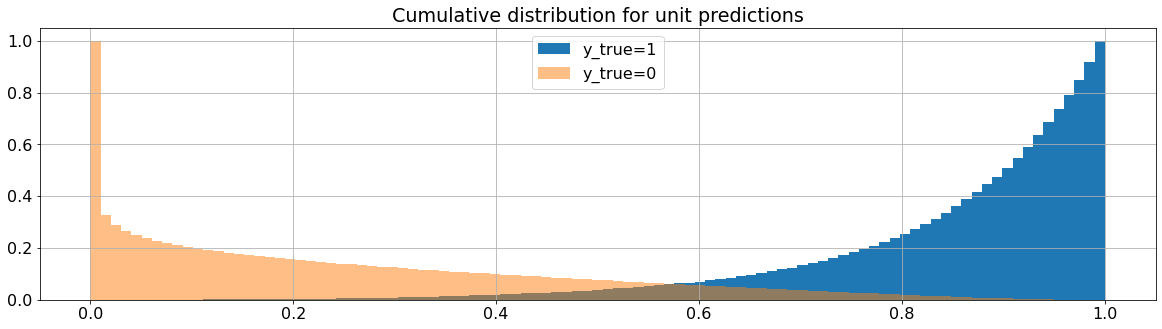

In [70]:
plot_cumulative_distributions(**get_y_true_y_pred(data, preds, name='unit'))

We can see that the EER lies below 10% at a threshold of around 0.55

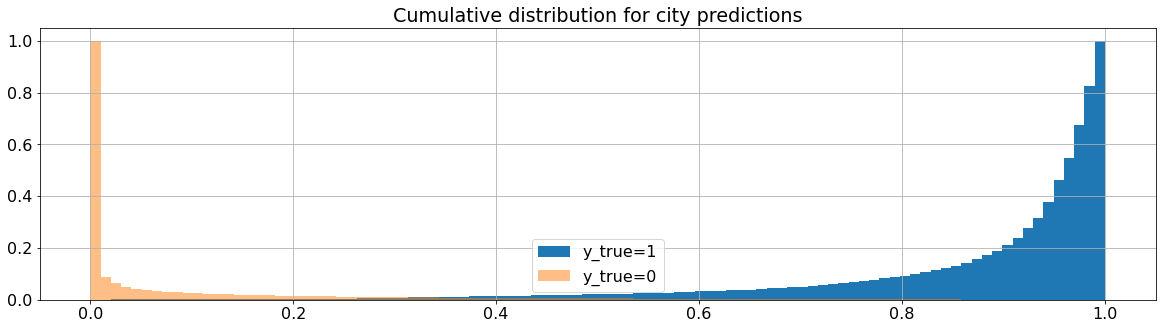

In [69]:
plot_cumulative_distributions(**get_y_true_y_pred(data, preds, name='city'))

In the case of cities the EER is really small.

#### Max predictions distributions

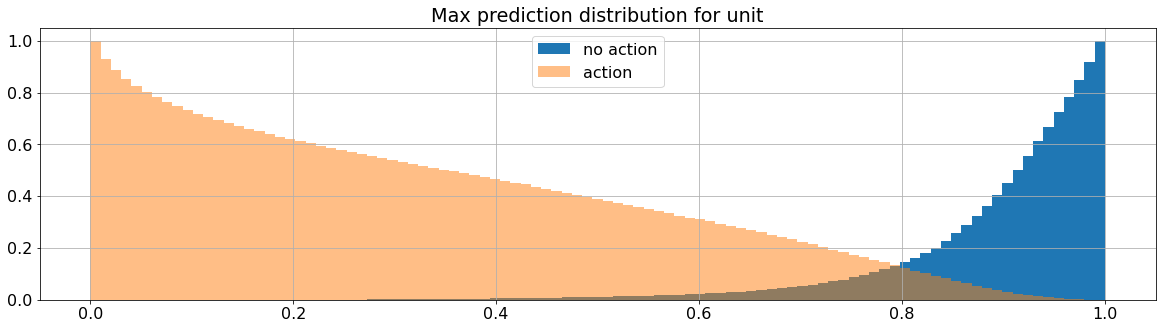

In [71]:
plot_max_prediction_distributions(**get_y_true_y_pred(data, preds, name='unit'))

If this is correct we are taking actions around 40% of the time that were not needed. This is probably caused by the white extracost.

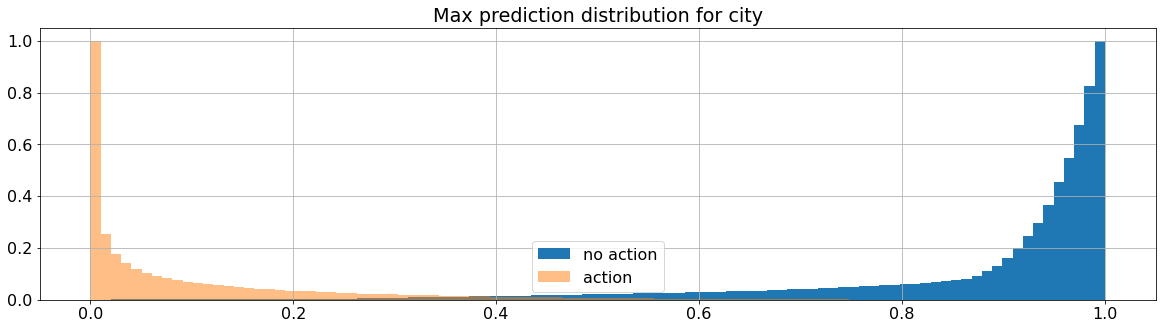

In [72]:
plot_max_prediction_distributions(**get_y_true_y_pred(data, preds, name='city'))

In the other hand for cities this works very well, it is almost perfect.

#### Importance of more than one unit actions

In [91]:
unique, counts = np.unique(np.sum(y_true, axis=1), return_counts=True)
for n_actions, frequency  in zip(unique, (counts/len(y_true)*100)):
    print('%i: %.2f%%' % (n_actions, frequency))

0: 63.34%
1: 36.44%
2: 0.22%
3: 0.01%


In [95]:
n_units = data[0][0][..., CHANNELS_MAP['player_worker']] + data[0][0][..., CHANNELS_MAP['player_cart']]
n_units = n_units[data[1][0][...,-1] == 1]
n_units.shape

(47745,)

In [97]:
for n, counts in zip(*np.unique(n_units, return_counts=True)):
    print('%i: %.2f%%' % (n, counts/len(n_units)*100))

1: 99.46%
2: 0.53%
3: 0.01%


Ok, so only 0.5% of the times there are 2 units on the same place, and only 0.22% of the times the two units need to take an action.

Thus it seems a very small fraction to worry with, metrics should focus on one action only.

#### Correct actions

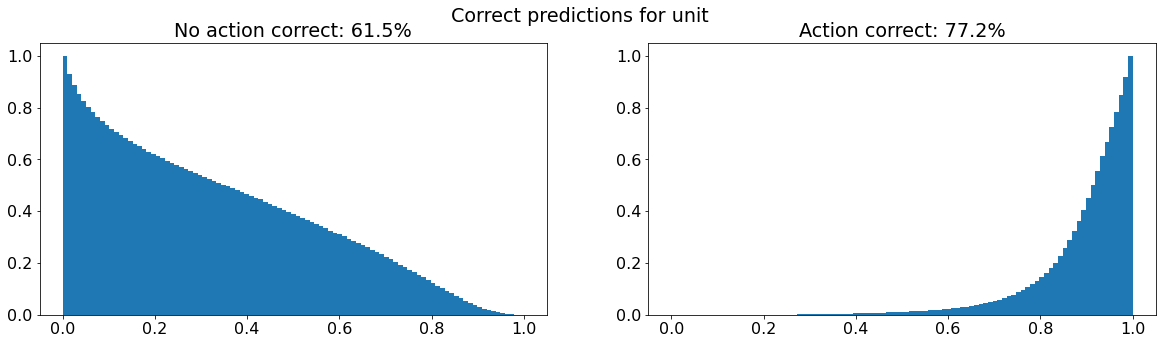

In [114]:
plot_correct_predictions(**get_y_true_y_pred(data, preds, name='unit'))

We can see that in the case of units is very frequent to take an action when is not needed. It takes the correct action 77.2% of the time.

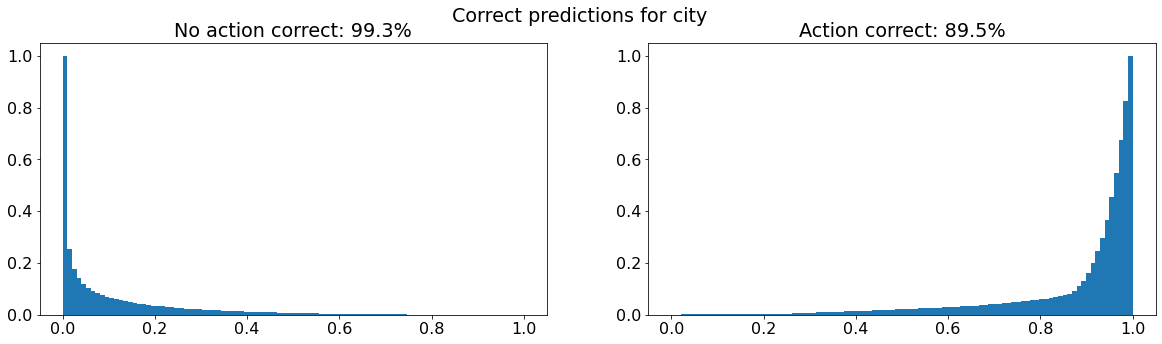

In [115]:
plot_correct_predictions(**get_y_true_y_pred(data, preds, name='city'))

On cities the behaviour is much better, probably because the action space is smaller.

#### Other

Just 0.2% of the predictions involve two actions. Thus we could create a metric that is designed for single prediction and it will probably work well.

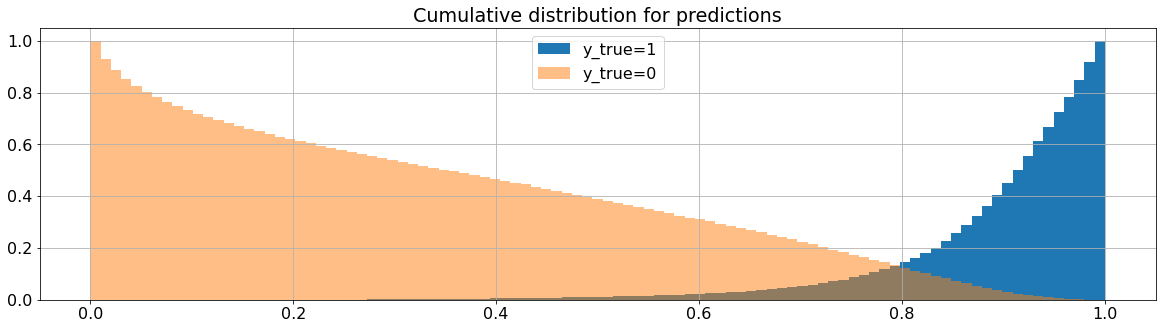

In [59]:
bins = np.linspace(0, 1, 100)
plt.hist(np.max(y_pred, axis=1)[np.max(y_true, axis=1) > 0], bins=bins, density=True, cumulative=1, label='y_true=1');
plt.hist(np.max(y_pred, axis=1)[np.max(y_true, axis=1) == 0], bins=bins, density=True, alpha=0.5, cumulative=-1, label='y_true=0');
plt.legend(loc=0)
plt.title('Cumulative distribution for predictions')
plt.grid();

## Summary

- We have found a big problem on unit actions, 40% of the time that the unit needs to stay without taking action it takes one. Cities do not have this problem.
- We have also found that is very rare to have 2 units on same position (0.5%) and even more rare to take 2 actions (0.2%)

I believe I have to change the model implementation to have 4 outputs. For each unit and city it will first predict wether to take an action and second the policy over the actions. This will split the responsability, give more freedom to the model and hopefully get a boost on the scores.

## Old thoughts

Is the prediction with higher value the same as the true label?  
Higher pred value when no action is needed?  
"Correct" predictions?  

When the targets are all zero -> we want all predictions below 0.5  
If some targets are one -> we want the min value of those predictions to be higher than the max of the other ones.

no action -> all predictions below 0.5 to be correct, we can show the distribution of the max value  
one action -> argmax should be the index of the action, the value should be above 0.5  
more than one actions -> we want the min value of those predictions to be higher than the max of the other ones, and the values above 0.5  

1. Create metrics for each group, print and visualize them
2. Can I implement those metrics with keras for tensorboard?
3. Can I think of a better loss function that better optimizes those metrics?

I might have 2 or 3 losses that are all computed but only applied depending on the values of the true labels, one loss for no action, another for one action...

Predicting 1s and 0s as the true labels will work, but other softer solutions will also work.

Maybe I have to add another channel that says action/no action. In that case if no action the loss on the other channels would be irrelevant. If action we could use softmax.

This will remove unbalance from the data, split responsability...

- How frequent is that two units are on the same place?
- In those cases how many times a single action is taken and more than one action are taken?